<a href="https://colab.research.google.com/github/revy1817/Data_Science-Numpy-Matplotlib-Scikit-learn-/blob/curse/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/Coursework/train.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/Coursework/test.csv'

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')


In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


# **EDA**

In [6]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

## Обработка выбросов в Rooms

In [8]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] >= 6) | (train_df['Rooms'] == 0), 'Rooms_outlier'] = 1

In [9]:
train_df[(train_df['Rooms'] >= 6) | (train_df['Rooms'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792,1
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646,1
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863,1
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788,1
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463,1
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704,1
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007,1
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887,1
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112,1
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416,1


Квартиры с аномальным количеством комнат приводим в соответствие с их площадью, в зависимости от средней площади с таким же количеством комнат

In [10]:
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)) & (train_df['Square'] >= train_df['Square'][train_df['Rooms'] >= 5].mean()), 'Rooms'] = 5
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)) & (train_df['Square'] >= train_df['Square'][train_df['Rooms'] >= 4].mean()), 'Rooms'] = 4
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)) & (train_df['Square'] >= train_df['Square'][train_df['Rooms'] >= 3].mean()), 'Rooms'] = 3
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)) & (train_df['Square'] >= train_df['Square'][train_df['Rooms'] >= 2].mean()), 'Rooms'] = 2
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)), 'Rooms'] = 1

In [11]:
train_df['Rooms'].value_counts()

2.0    3880
1.0    3713
3.0    2237
4.0     150
5.0      20
Name: Rooms, dtype: int64

## Обработка выбросов в Square

In [12]:
train_df[train_df['Square'] > 300]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538,0
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830,0
9229,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562,0


In [13]:
train_df['Square_outlier'] = 0
train_df.loc[train_df['Square'] > 300, 'Square_outlier'] = 1

In [14]:
train_df.loc[(train_df['Square'] > 300) & (train_df['Rooms'] == 2), 'Square'] = train_df['Square'][train_df['Rooms'] == 2].median()
train_df.loc[(train_df['Square'] > 300) & (train_df['Rooms'] == 1), 'Square'] = train_df['Square'][train_df['Rooms'] == 1].median()

In [15]:
train_df.loc[(train_df['Square'] < 10) & (train_df['Square'] < train_df['LifeSquare']), 'Square_outlier'] = 1

In [16]:
train_df.loc[(train_df['Square'] < 10) & (train_df['Square'] < train_df['LifeSquare']), 'Square'] = train_df.loc[(train_df['Square'] < 10) & (train_df['Square'] < train_df['LifeSquare']), 'LifeSquare'] * 1.25

## Обработка выбросов в LifeSquare

In [17]:
train_df[train_df['LifeSquare'] > 250]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier
357,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.231857,0,0
5183,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978,0,0
7010,2307,102,1.0,40.412437,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830,0,1
8000,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366,0,0
9229,11602,30,2.0,55.841812,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562,0,1


In [18]:
train_df['LifeSquare_outlier'] = 0
train_df.loc[train_df['LifeSquare'] > 250, 'LifeSquare_outlier'] = 1

In [19]:
train_df.loc[train_df['LifeSquare'] > 250, 'LifeSquare'] = train_df.loc[train_df['LifeSquare'] > 250, 'Square'] * 0.75

## Обработка выбросов в KitchenSquare

In [20]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

Находим самые большие квартиры и смотрим на размеры их кухонь, тем самым определя верхнюю границу кухни

In [21]:
train_df[train_df['Square'] > 150]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier
403,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B,622888.825328,0,0,0
730,14181,62,3.0,156.636577,153.685835,1.0,1,3.0,2005,0.072158,B,B,2,629,1,NaN,0,0,A,502523.573863,0,0,0
1449,11764,93,3.0,169.117203,NaN,1.0,5,3.0,1977,0.004949,B,B,0,186,0,NaN,0,0,B,211325.577641,0,0,0
1606,3718,56,3.0,190.857689,107.376164,19.0,7,3.0,2007,0.000000,B,B,23,5067,4,NaN,2,6,B,338644.075979,0,0,0
1776,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016,0,0,0
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666,0,0,0
2066,14556,183,4.0,151.150660,98.187482,23.0,6,7.0,1912,0.037316,B,B,32,6748,93,562.0,4,10,B,284884.959104,0,0,0
2790,15947,129,4.0,185.906396,84.830074,31.0,5,3.0,2015,0.020741,B,B,24,5613,5,1340.0,2,5,B,340273.238253,0,0,0
3182,3914,24,4.0,155.930023,76.831293,15.0,6,22.0,2012,0.111627,B,B,50,12238,8,1970.0,2,3,B,559886.965348,0,0,0
3204,5621,23,3.0,163.495333,161.504222,12.0,5,3.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,207007.956663,0,0,0


Самая большая кухня в большой квартире 32, значит кухни с большим размером будут считаться выбросом

Находим процетное соотношение размеров кухни относительно всего жилья, не включая в расчеты выбросы по кухне

In [22]:
train_df['KitchenSquare'][(train_df['KitchenSquare'] > 3) & (train_df['KitchenSquare'] < 33)].sum() / train_df['Square'][(train_df['KitchenSquare'] > 3) & (train_df['KitchenSquare'] < 33)].sum()

0.14716959593665277

Примерно 14% занимают кухни в квартирах

Заменим выбросные значения на среднее значения относительно площади квартиры

In [23]:
train_df['KitchenSquare_outlier'] = 0
train_df.loc[(train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'] > 33), 'KitchenSquare_outlier'] = 1

In [24]:
train_df.loc[(train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'] > 33), 'KitchenSquare'] = train_df.loc[(train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'] > 33), 'Square'] * 0.14

In [25]:
train_df[train_df['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier
161,6782,45,1.0,6.571598,5.257278,0.920024,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323,0,1,0,1
328,4504,27,3.0,7.013465,5.610772,0.981885,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,0,1,0,1
1401,9487,5,1.0,6.936822,5.549458,0.971155,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,0,1,0,1
4496,15744,34,1.0,3.302773,2.642219,0.462388,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006,0,1,0,1
4800,7657,38,1.0,5.773183,4.618547,0.808246,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083,0,1,0,1
5009,11526,27,1.0,4.633498,1.969969,0.648690,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441,0,0,0,1
5870,6927,21,1.0,16.117154,8.822988,2.256402,2,5.0,1965,0.194489,B,B,47,8004,3,125.0,3,5,B,79913.267856,0,0,0,1
6379,6351,111,1.0,20.606762,14.740084,2.884947,4,15.0,1975,0.135650,B,B,46,7960,6,350.0,3,11,B,108379.889782,0,0,0,1
6632,13685,0,1.0,17.498542,13.446544,2.449796,7,5.0,1961,0.319809,B,B,25,4756,16,2857.0,5,8,B,88871.750230,0,0,0,1
7209,14236,0,1.0,19.927423,15.541536,2.789839,2,5.0,1962,0.319809,B,B,25,4756,16,2857.0,5,8,B,102395.788856,0,0,0,1


In [26]:
train_df[train_df['KitchenSquare'] > 40]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier


In [27]:
train_df['KitchenSquare'].value_counts()

8.000000     1306
5.000000     1169
10.000000    1075
6.000000     1038
9.000000      843
             ... 
9.114282        1
17.058161       1
9.319384        1
9.215584        1
10.427617       1
Name: KitchenSquare, Length: 3222, dtype: int64

## Обработка выбросов в Floor & HouseFloor

In [28]:
train_df['HouseFloor'].describe()

count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [29]:
train_df['Floor'].describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

Узнаем общее количество домов, где этаж равен 0 либо 1, в дата сете представлены только квартиры, следовательно дома с этажностью в 1 этаж наиболее вероятно являются выбросами 

In [30]:
train_df[train_df['HouseFloor'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier
25,4521,6,2.0,65.409965,NaN,9.157395,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608,0,0,0,1
26,8553,88,3.0,83.262530,4.769174,11.656754,13,1.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,410883.892020,0,0,0,1
44,9024,6,3.0,79.790762,NaN,11.170707,16,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193595.800511,0,0,0,1
47,6186,1,1.0,62.006079,NaN,8.680851,7,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,197006.124188,0,0,0,1
71,13726,27,1.0,47.557691,22.682321,6.658077,16,1.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,130190.643579,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,4956,27,1.0,44.881534,NaN,6.283415,3,1.0,1977,0.011320,B,B,2,568,1,NaN,0,0,B,74910.831539,0,0,0,1
9870,1178,9,3.0,82.247909,80.049163,11.514707,9,1.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,236541.355539,0,0,0,1
9912,13523,23,1.0,52.787090,5.600609,7.390193,7,1.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B,104160.492175,0,0,0,1
9938,2913,34,4.0,94.888593,2.637095,13.284403,4,1.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,346949.506507,0,0,0,1


In [31]:
train_df[train_df['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier
24,4717,27,1.0,44.203947,NaN,6.188553,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,0,0,0,1
152,12947,53,2.0,56.023342,NaN,7.843268,14,0.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,247074.564832,0,0,0,1
159,13146,74,1.0,46.449711,NaN,6.502960,6,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,168705.450148,0,0,0,1
186,12174,62,1.0,44.954880,NaN,6.293683,8,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,133773.301722,0,0,0,1
229,15661,45,3.0,81.094922,NaN,11.353289,15,0.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,442472.456032,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,629,27,1.0,42.936724,NaN,6.011141,2,0.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,129674.841139,0,0,0,1
9931,15686,1,1.0,47.402412,NaN,6.636338,14,0.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,174740.301224,0,0,0,1
9940,4711,6,1.0,41.224118,NaN,5.771377,8,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,125612.639104,0,0,0,1
9950,5383,48,3.0,98.994909,NaN,13.859287,3,0.0,1977,0.041125,B,B,46,9515,5,NaN,1,10,B,418817.004446,0,0,0,1


Приводим нулевые и одно этажные дома к этажности квартиры

In [32]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[(train_df['HouseFloor'] <= 1) | ((train_df['HouseFloor'] > 25) & (train_df['HouseYear'] < 2000)), 'HouseFloor_outlier'] = 1

In [33]:
train_df.loc[train_df['HouseFloor'] <= 1, 'HouseFloor'] = train_df.loc[train_df['HouseFloor'] <= 1, 'Floor']

До 2000 годов этажность домов не превышала 25 этажа, следоватльно дома с большой этажностью до этого года являются выбросами

In [34]:
train_df[(train_df['HouseFloor'] > 25) & (train_df['HouseYear'] < 2000)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier
746,9300,74,2.0,71.747869,74.579809,9.000000,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579,0,0,0,0,1
1038,15270,31,2.0,81.042938,46.633001,16.000000,15,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,547586.080087,0,0,0,0,1
1360,3298,31,1.0,57.551691,21.551876,10.000000,32,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,393799.531732,0,0,0,0,1
1678,78,30,2.0,65.773749,66.811789,9.208325,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520,0,0,0,1,1
2383,8016,31,1.0,59.519896,24.050533,10.000000,33,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,389554.063540,0,0,0,0,1
4657,10806,5,1.0,51.944587,48.709601,7.272242,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515,0,0,0,1,1
4800,7657,38,1.0,5.773183,4.618547,0.808246,28,28.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083,0,1,0,1,1
5799,2377,34,2.0,57.350700,NaN,10.000000,25,30.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,343821.934744,0,0,0,0,1
9087,13202,34,2.0,62.874315,NaN,8.802404,26,26.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,279097.884511,0,0,0,1,1
9357,7862,27,3.0,48.652482,NaN,6.811347,26,26.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,178621.891030,0,0,0,1,1


Заменим этажность домов выше построенных до 2000, до 25 этажа

In [35]:
train_df.loc[(train_df['HouseFloor'] > 25) & (train_df['HouseYear'] < 2000), 'HouseFloor'] = 25

In [36]:
train_df['Id'][train_df['Floor'] > train_df['HouseFloor']].count()

1077

1077 домов где этаж квартиры превышает этаж дома, изменим значения в деапозоне от 2 этажа до максималнього этажа дома 

In [37]:
train_df['Floor_outlier'] = 0
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor_outlier'] = 1

In [38]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor']\
                                                .apply(lambda x: random.randint(2, x))

## Обработка выбросов в HouseYear

In [39]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [40]:
train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear_outlier'] = 1

In [41]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [42]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier
count,10000.00000,10000.000000,10000.00000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.88840,56.189352,36.055223,8.127725,7.919600,13.239400,1984.872400,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.001200,0.001300,0.000500,0.319400,0.07730,0.107700,0.000200
std,4859.01902,43.587592,0.81278,19.131767,17.831056,2.648949,5.001823,5.935471,18.416347,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.034622,0.036034,0.022356,0.466267,0.26708,0.310017,0.014141
min,0.00000,0.000000,1.00000,2.377248,0.370619,0.332815,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,4169.50000,20.000000,1.00000,41.780320,22.769832,6.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,8394.50000,36.000000,2.00000,52.519197,32.772431,8.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,12592.50000,75.000000,2.00000,65.894295,45.107755,10.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
max,16798.00000,209.000000,5.00000,275.645284,233.949309,32.000000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


# **Обработка пропусков**

In [43]:
train_df.isna().sum()

Id                          0
DistrictId                  0
Rooms                       0
Square                      0
LifeSquare               2113
KitchenSquare               0
Floor                       0
HouseFloor                  0
HouseYear                   0
Ecology_1                   0
Ecology_2                   0
Ecology_3                   0
Social_1                    0
Social_2                    0
Social_3                    0
Healthcare_1             4798
Helthcare_2                 0
Shops_1                     0
Shops_2                     0
Price                       0
Rooms_outlier               0
Square_outlier              0
LifeSquare_outlier          0
KitchenSquare_outlier       0
HouseFloor_outlier          0
Floor_outlier               0
HouseYear_outlier           0
dtype: int64

In [44]:
train_df['LifeSquare_nan'] = 0
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1

In [45]:
condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare']

В Healthcare_1 почти 50% пропусков, не видно адекватной замены данных

In [46]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

# **Построение новых признаков**

## Бинарные признаки

In [47]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [48]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
205      1
174      1
209      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [49]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [50]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,105.027311,10.000000,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,0,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,0,0,0,652
3,2352,1,1.0,40.409907,34.752520,5.657387,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,1,0,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,0,0,0,89


In [51]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [52]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

## Средняя цена за квадрат

In [53]:
mean_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False)['Square', 'Price'].agg('sum')\
                           .rename(columns={'Price':'MeanPriceByDistrict'})

mean_price_by_district['Square_p'] = mean_price_by_district['MeanPriceByDistrict'] / mean_price_by_district['Square']
mean_price_by_district.drop(['Square', 'MeanPriceByDistrict'], axis=1, inplace=True)
mean_price_by_district

,DistrictId,Rooms,Square_p
0,0,1.0,3463.503027
1,0,2.0,3525.858298
2,0,3.0,3768.052621
3,1,1.0,3374.443391
4,1,2.0,3154.583700
...,...,...,...
662,202,3.0,3040.402573
663,205,1.0,5101.016598
664,207,3.0,5550.678339
665,208,2.0,8004.659114


In [54]:
#mean_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
#                            .rename(columns={'Price':'Square_p'})
                            
#mean_price_by_district['Square_p'] = (mean_price_by_district['Square_p']) / (train_df['Price'].median())

#mean_price_by_district


In [55]:
train_df = train_df.merge(mean_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,Square_p
0,11809,27,3.0,115.027311,105.027311,10.000000,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,0,0,0,1,851,1,2711.919155
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,0,0,0,78,0,3894.465539
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,0,0,0,652,1,2970.400574
3,2352,1,1.0,40.409907,34.752520,5.657387,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,1,0,0,0,1,652,1,3374.443391
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,0,0,0,89,0,4142.816199


mean_price_by_district_1 и mean_price_by_district_2 для обработки TEST

In [56]:
mean_price_by_district_1 = train_df.groupby(['DistrictId'], as_index=False)['Square', 'Price'].agg('sum')\
                           .rename(columns={'Price':'MeanPriceByDistrict'})

mean_price_by_district_1['Square_p_a'] = mean_price_by_district_1['MeanPriceByDistrict'] / mean_price_by_district_1['Square']
mean_price_by_district_1.drop(['Square', 'MeanPriceByDistrict'], axis=1, inplace=True)
mean_price_by_district_1

,DistrictId,Square_p_a
0,0,3580.128227
1,1,3167.045517
2,2,4523.617804
3,3,3588.170925
4,4,4490.922499
...,...,...
200,202,5775.486120
201,205,5101.016598
202,207,5550.678339
203,208,8004.659114


In [57]:
mean_price_by_district_2 = train_df.groupby(['Rooms'], as_index=False)['Square', 'Price'].agg('sum')\
                            .rename(columns={'Price':'MeanPriceByDistrict'})

mean_price_by_district_2['Square_p_a'] = mean_price_by_district_2['MeanPriceByDistrict'] / mean_price_by_district_2['Square']
mean_price_by_district_2.drop(['Square', 'MeanPriceByDistrict'], axis=1, inplace=True)
mean_price_by_district_2

,Rooms,Square_p_a
0,1.0,3876.242679
1,2.0,3808.747740
2,3.0,3759.044090
3,4.0,3895.717326
4,5.0,3110.649116


## Этаж и год

In [58]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X

def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X

In [59]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,Square_p,year_cat,floor_cat
0,11809,27,3.0,115.027311,105.027311,10.000000,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,0,0,0,1,851,1,2711.919155,6,2
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,0,0,0,78,0,3894.465539,3,3
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,0,0,0,652,1,2970.400574,4,1
3,2352,1,1.0,40.409907,34.752520,5.657387,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,1,0,0,0,1,652,1,3374.443391,3,4
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,0,0,0,89,0,4142.816199,3,5


In [60]:
mean_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'mean'}).\
                                            rename(columns={'Price':'MeanPriceByFloorYear'})
mean_price_by_floor_year.head()

,year_cat,floor_cat,MeanPriceByFloorYear
0,1,1,330007.706254
1,1,2,347609.080839
2,1,3,376370.694356
3,1,4,274992.472366
4,2,1,467230.539057


In [61]:
train_df = train_df.merge(mean_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,Square_p,year_cat,floor_cat,MeanPriceByFloorYear
0,11809,27,3.0,115.027311,105.027311,10.000000,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,0,0,0,1,851,1,2711.919155,6,2,185849.082372
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,0,0,0,78,0,3894.465539,3,3,206463.813289
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,0,0,0,652,1,2970.400574,4,1,222721.352017
3,2352,1,1.0,40.409907,34.752520,5.657387,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,1,0,0,0,1,652,1,3374.443391,3,4,195969.919990
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,0,0,0,89,0,4142.816199,3,5,201548.352028


## Social_price

In [62]:
train_df['Social_2'].describe()

count    10000.000000
mean      5352.157400
std       4006.799803
min        168.000000
25%       1564.000000
50%       5285.000000
75%       7227.000000
max      19083.000000
Name: Social_2, dtype: float64

In [63]:
def social_to_cat(X):
    X['social_cat'] = 0
    
    X.loc[X['Social_2'] <= 1564, 'social_cat'] = 1
    X.loc[(X['Social_2'] > 1564) & (X['Social_2'] <= 5285), 'social_cat'] = 2
    X.loc[X['Social_2'] >= 5285, 'social_cat'] = 3
    
    return X

In [64]:
train_df = social_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,Square_p,year_cat,floor_cat,MeanPriceByFloorYear,social_cat
0,11809,27,3.0,115.027311,105.027311,10.000000,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,0,0,0,1,851,1,2711.919155,6,2,185849.082372,2
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,0,0,0,78,0,3894.465539,3,3,206463.813289,3
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,0,0,0,652,1,2970.400574,4,1,222721.352017,2
3,2352,1,1.0,40.409907,34.752520,5.657387,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,1,0,0,0,1,652,1,3374.443391,3,4,195969.919990,1
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,0,0,0,89,0,4142.816199,3,5,201548.352028,3


In [65]:
med_price_by_social = train_df.groupby(['social_cat', 'DistrictId'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial'})
med_price_by_social.head()

,social_cat,DistrictId,MedPriceBySocial
0,1,1,181580.024287
1,1,6,168980.370846
2,1,21,159530.416728
3,1,23,113789.561738
4,1,27,150618.085728


In [66]:
train_df = train_df.merge(med_price_by_social, on=['social_cat', 'DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,Square_p,year_cat,floor_cat,MeanPriceByFloorYear,social_cat,MedPriceBySocial
0,11809,27,3.0,115.027311,105.027311,10.000000,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,0,0,0,1,851,1,2711.919155,6,2,185849.082372,2,125903.060920
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,0,0,0,78,0,3894.465539,3,3,206463.813289,3,183678.134031
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,0,0,0,652,1,2970.400574,4,1,222721.352017,2,203858.095745
3,2352,1,1.0,40.409907,34.752520,5.657387,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,1,0,0,0,1,652,1,3374.443391,3,4,195969.919990,1,181580.024287
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,0,0,0,89,0,4142.816199,3,5,201548.352028,3,181706.718894


In [67]:
train_df['Social_2'].describe()

count    10000.000000
mean      5352.157400
std       4006.799803
min        168.000000
25%       1564.000000
50%       5285.000000
75%       7227.000000
max      19083.000000
Name: Social_2, dtype: float64

## Ecology cat & ecology_price

In [68]:
def ecology_to_cat(X):
    X['ecology_cat'] = 0
    
    X.loc[X['Ecology_1'] <= 0.1, 'ecology_cat'] = 1
    X.loc[(X['Ecology_1'] > 0.1) & (X['Ecology_1'] <= 0.2), 'ecology_cat'] = 2
    X.loc[(X['Ecology_1'] > 0.2) & (X['Ecology_1'] <= 0.3), 'ecology_cat'] = 3
    X.loc[(X['Ecology_1'] > 0.3) & (X['Ecology_1'] <= 0.4), 'ecology_cat'] = 4
    X.loc[X['Ecology_1'] > 0.4, 'ecology_cat'] = 5
    
    return X

In [69]:
train_df = ecology_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,Square_p,year_cat,floor_cat,MeanPriceByFloorYear,social_cat,MedPriceBySocial,ecology_cat
0,11809,27,3.0,115.027311,105.027311,10.000000,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,0,0,0,1,851,1,2711.919155,6,2,185849.082372,2,125903.060920,1
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,0,0,0,78,0,3894.465539,3,3,206463.813289,3,183678.134031,2
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,0,0,0,652,1,2970.400574,4,1,222721.352017,2,203858.095745,1
3,2352,1,1.0,40.409907,34.752520,5.657387,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,1,0,0,0,1,652,1,3374.443391,3,4,195969.919990,1,181580.024287,1
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,0,0,0,89,0,4142.816199,3,5,201548.352028,3,181706.718894,3


In [70]:
med_price_by_age_ecology = train_df.groupby(['year_cat', 'ecology_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByAgeEcology'})
med_price_by_age_ecology.head()

,year_cat,ecology_cat,MedPriceByAgeEcology
0,1,1,380359.112959
1,1,2,236835.553871
2,1,3,333877.704698
3,1,4,342362.949065
4,1,5,300441.280273


In [71]:
train_df = train_df.merge(med_price_by_age_ecology, on=['year_cat', 'ecology_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,Square_p,year_cat,floor_cat,MeanPriceByFloorYear,social_cat,MedPriceBySocial,ecology_cat,MedPriceByAgeEcology
0,11809,27,3.0,115.027311,105.027311,10.000000,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,0,0,0,1,851,1,2711.919155,6,2,185849.082372,2,125903.060920,1,171399.139867
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,0,0,0,78,0,3894.465539,3,3,206463.813289,3,183678.134031,2,197602.873666
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,0,0,0,652,1,2970.400574,4,1,222721.352017,2,203858.095745,1,236599.144587
3,2352,1,1.0,40.409907,34.752520,5.657387,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,1,0,0,0,1,652,1,3374.443391,3,4,195969.919990,1,181580.024287,1,184805.775400
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,0,0,0,89,0,4142.816199,3,5,201548.352028,3,181706.718894,3,173654.551775


## health_cat

In [72]:
med_price_by_ecology_Helth = train_df.groupby(['Helthcare_2'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByEcologyHelth'})
med_price_by_ecology_Helth.head()


,Helthcare_2,MedPriceByEcologyHelth
0,0,169383.062017
1,1,216133.463865
2,2,198882.369296
3,3,204197.976965
4,4,240621.376196


In [73]:
train_df = train_df.merge(med_price_by_ecology_Helth, on=['Helthcare_2'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,Square_p,year_cat,floor_cat,MeanPriceByFloorYear,social_cat,MedPriceBySocial,ecology_cat,MedPriceByAgeEcology,MedPriceByEcologyHelth
0,11809,27,3.0,115.027311,105.027311,10.000000,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,0,0,0,1,851,1,2711.919155,6,2,185849.082372,2,125903.060920,1,171399.139867,169383.062017
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,0,0,0,78,0,3894.465539,3,3,206463.813289,3,183678.134031,2,197602.873666,216133.463865
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,0,0,0,652,1,2970.400574,4,1,222721.352017,2,203858.095745,1,236599.144587,204197.976965
3,2352,1,1.0,40.409907,34.752520,5.657387,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,1,0,0,0,1,652,1,3374.443391,3,4,195969.919990,1,181580.024287,1,184805.775400,169383.062017
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,0,0,0,89,0,4142.816199,3,5,201548.352028,3,181706.718894,3,173654.551775,169383.062017


# **Функции**

In [74]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] >= 6) | (X['Rooms'] == 0), 'Rooms_outlier'] = 1
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] >= 6)) & (X['Square'] >= X['Square'][X['Rooms'] >= 5].mean()), 'Rooms'] = 5
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] >= 6)) & (X['Square'] >= X['Square'][X['Rooms'] >= 4].mean()), 'Rooms'] = 4
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] >= 6)) & (X['Square'] >= X['Square'][X['Rooms'] >= 3].mean()), 'Rooms'] = 3
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] >= 6)) & (X['Square'] >= X['Square'][X['Rooms'] >= 2].mean()), 'Rooms'] = 2
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] >= 6)), 'Rooms'] = 1

        # Square
        X['Square_outlier'] = 0
        X.loc[X['Square'] > 300, 'Square_outlier'] = 1

        X.loc[(X['Square'] > 300) & (X['Rooms'] == 2), 'Square'] = X['Square'][X['Rooms'] == 2].mean()
        X.loc[(X['Square'] > 300) & (X['Rooms'] == 1), 'Square'] = X['Square'][X['Rooms'] == 1].mean()

        X.loc[(X['Square'] < 10) & (X['Square'] < X['LifeSquare']), 'Square_outlier'] = 1
        X.loc[(X['Square'] < 10) & (X['Square'] < X['LifeSquare']), 'Square'] = X.loc[(X['Square'] < 10) & (X['Square'] < X['LifeSquare']), 'LifeSquare'] * 1.25

        # LifeSquare
        X['LifeSquare_outlier'] = 0
        X.loc[X['LifeSquare'] > 250, 'LifeSquare_outlier'] = 1

        X.loc[X['LifeSquare'] > 250, 'LifeSquare'] = X.loc[X['LifeSquare'] > 250, 'Square'] * 0.75


        # KitchenSquare
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['KitchenSquare'] < 3) | (X['KitchenSquare'] > 33), 'KitchenSquare_outlier'] = 1

        X.loc[(X['KitchenSquare'] < 3) | (X['KitchenSquare'] > 33), 'KitchenSquare'] = X.loc[(X['KitchenSquare'] < 3) | (X['KitchenSquare'] > 33), 'Square'] * 0.14
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'] <= 1) | ((X['HouseFloor'] > 25) & (X['HouseYear'] < 2000)), 'HouseFloor_outlier'] = 1

        X.loc[X['HouseFloor'] <= 1, 'HouseFloor'] = X.loc[X['HouseFloor'] <= 1, 'Floor']
        X.loc[(X['HouseFloor'] > 25) & (X['HouseYear'] < 2000), 'HouseFloor'] = 25

        X['Floor_outlier'] = 0
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor_outlier'] = 1

        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']\
                                                .apply(lambda x: random.randint(2, x))
        
        # HouseYear
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > 2020, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        
        return X

# **Отбор признаков**

In [75]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Square_outlier',
 'LifeSquare_outlier',
 'KitchenSquare_outlier',
 'HouseFloor_outlier',
 'Floor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'Square_p',
 'year_cat',
 'floor_cat',
 'MeanPriceByFloorYear',
 'social_cat',
 'MedPriceBySocial',
 'ecology_cat',
 'MedPriceByAgeEcology',
 'MedPriceByEcologyHelth']

In [76]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'Square_outlier', 'LifeSquare_outlier', 'KitchenSquare_outlier', 'HouseFloor_outlier', 'Floor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
                      'MeanPriceByFloorYear', 'MedPriceByAgeEcology', 'MedPriceByEcologyHelth', 'MedPriceBySocial', 'Square_p', 'DistrictSize', 'IsDistrictLarge']


target_name = 'Price'

# **Разбиение на train и test**

In [77]:
target = train_df[target_name]
train_df.drop(columns=target_name, axis=1, inplace=True)

In [78]:
X = train_df
y = target

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [79]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]

# **Построение модели**

In [107]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     random_state=42,  
                                     n_estimators=125)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=125,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Train R2:	0.898
Test R2:	0.779


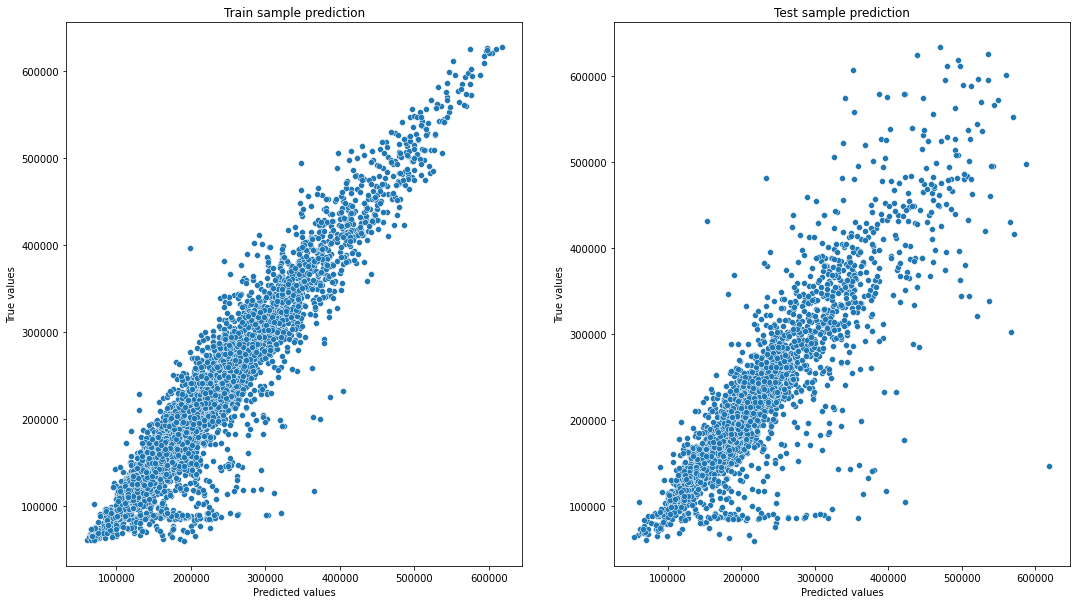

In [108]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [109]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.435499
29,Square_p,0.276556
28,MedPriceBySocial,0.137260
1,Rooms,0.025706
25,MeanPriceByFloorYear,0.015963
26,MedPriceByAgeEcology,0.013296
3,LifeSquare,0.013128
6,HouseFloor,0.011782
12,Social_2,0.010957
4,KitchenSquare,0.009179


In [110]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse', max_depth=11, n_estimators=150)

In [111]:
rf2 = RandomForestRegressor(
    random_state=21, 
    max_depth=14, 
    criterion='mse',
    max_features=7, 
    n_jobs=-1,
    n_estimators=200  
)

In [112]:
gb_1 = GradientBoostingRegressor(
                               max_depth=4,
                               min_samples_leaf=20,
                               random_state=21,  
                               n_estimators=100
                              )

In [113]:
rf_5 = RandomForestRegressor(
    random_state=21, 
    max_depth=40,  # gridsearch
    criterion='mse',
    min_samples_leaf=5,  # gridsearch
    n_jobs=-1,
    n_estimators=1000  # gridsearch
)

In [114]:
rf3 = RandomForestRegressor(
    max_depth=20,
    random_state=21, 
)

In [115]:
rf4 = RandomForestRegressor(
    random_state=21, 
)

In [116]:
import xgboost as xgb

xg=xgb.XGBRegressor(
                  random_state=21,
                  n_estimators=5, 
                  n_jobs=-1,
                  subsample=0.5,
                  colsample_bynode=0.5,
                  num_parallel_tree=100,
                  learning_rate=0.5,
                  max_depth=3
                  )

In [117]:
from sklearn.ensemble import StackingRegressor

stack_2 = StackingRegressor([
                           ('rf', rf_model),
                           ('rf2', rf2),
                           ('rf3', rf3),
                           ('rf4', rf4),
                           ('rf5', rf_5),
                           ('gb', gb_1), 
                           ('xg', xg),
                          ],
                          cv=5,
                          n_jobs=-1,
                          final_estimator=GradientBoostingRegressor(
                               
                               max_depth=1,
                               random_state=21,  
                               n_estimators=125,
                               
                          )
                         )

In [119]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor

stack = VotingRegressor([('gb', gb_model), ('rf', rf_model), ('rf2', rf2), ('stack', stack_2)])
stack.fit(X_train, y_train)

VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                             

Train R2:	0.924
Test R2:	0.786


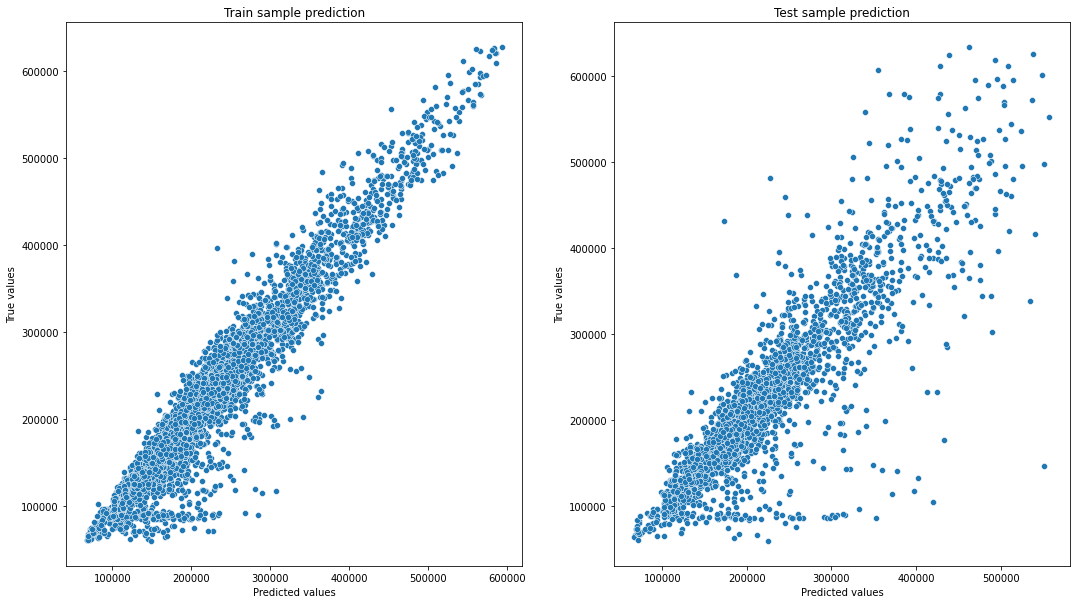

In [120]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# **Test_df**

In [121]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [122]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


In [123]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [124]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Coursework/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [125]:
preprocessor = DataPreprocessing()
test_df = preprocessor.transform(test_df)

In [126]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan
0,4567,44,1.0,36.847630,19.094182,5.000000,5,9.0,1970,0.036122,B,B,24,4378,0,1,1,B,0,0,0,0,0,0,0,0
1,5925,62,1.0,42.493907,42.568133,10.000000,7,17.0,2017,0.072158,B,B,2,629,1,0,0,A,0,0,0,0,0,0,0,0
2,960,27,2.0,59.463678,47.463678,9.000000,19,19.0,1977,0.211401,B,B,9,1892,0,0,1,B,0,0,0,0,0,0,0,1
3,3848,23,3.0,49.646030,33.893825,6.000000,2,2.0,1965,0.014073,B,B,2,475,0,0,0,B,0,0,0,0,0,0,0,0
4,746,74,1.0,53.837056,43.299868,7.537188,8,17.0,1977,0.309479,B,B,35,7715,4,0,6,B,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.000000,3,5.0,1962,0.069660,B,B,31,6119,4,1,2,B,0,0,0,0,0,1,0,0
4996,16138,38,3.0,93.698122,94.521465,10.000000,21,27.0,2018,0.060753,B,B,15,2787,2,0,7,B,0,0,0,0,0,0,0,0
4997,3912,101,1.0,33.656723,19.003259,5.000000,2,5.0,1966,0.038693,B,B,28,6533,1,2,5,B,0,0,0,0,0,0,0,0
4998,5722,10,1.0,38.635155,20.976257,9.000000,8,14.0,1970,0.089040,B,B,33,7976,5,0,11,B,0,0,0,0,0,0,0,0


In [127]:
test_df = test_df.merge(mean_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,Square_p
0,4567,44,1.0,36.847630,19.094182,5.000000,5,9.0,1970,0.036122,B,B,24,4378,0,1,1,B,0,0,0,0,0,0,0,0,4842.386950
1,5925,62,1.0,42.493907,42.568133,10.000000,7,17.0,2017,0.072158,B,B,2,629,1,0,0,A,0,0,0,0,0,0,0,0,2836.051329
2,960,27,2.0,59.463678,47.463678,9.000000,19,19.0,1977,0.211401,B,B,9,1892,0,0,1,B,0,0,0,0,0,0,0,1,2604.040542
3,3848,23,3.0,49.646030,33.893825,6.000000,2,2.0,1965,0.014073,B,B,2,475,0,0,0,B,0,0,0,0,0,0,0,0,2118.356263
4,746,74,1.0,53.837056,43.299868,7.537188,8,17.0,1977,0.309479,B,B,35,7715,4,0,6,B,0,0,0,1,0,0,0,1,3413.442877


In [128]:
test_df = year_to_cat(test_df)
test_df = floor_to_cat(test_df)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,Square_p,year_cat,floor_cat
0,4567,44,1.0,36.847630,19.094182,5.000000,5,9.0,1970,0.036122,B,B,24,4378,0,1,1,B,0,0,0,0,0,0,0,0,4842.386950,3,2
1,5925,62,1.0,42.493907,42.568133,10.000000,7,17.0,2017,0.072158,B,B,2,629,1,0,0,A,0,0,0,0,0,0,0,0,2836.051329,6,3
2,960,27,2.0,59.463678,47.463678,9.000000,19,19.0,1977,0.211401,B,B,9,1892,0,0,1,B,0,0,0,0,0,0,0,1,2604.040542,3,5
3,3848,23,3.0,49.646030,33.893825,6.000000,2,2.0,1965,0.014073,B,B,2,475,0,0,0,B,0,0,0,0,0,0,0,0,2118.356263,3,1
4,746,74,1.0,53.837056,43.299868,7.537188,8,17.0,1977,0.309479,B,B,35,7715,4,0,6,B,0,0,0,1,0,0,0,1,3413.442877,3,3


In [129]:
test_df = test_df.merge(mean_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,Square_p,year_cat,floor_cat,MeanPriceByFloorYear,social_cat,MedPriceBySocial,ecology_cat,MedPriceByAgeEcology,MedPriceByEcologyHelth
0,11809,27,3.0,115.027311,105.027311,10.000000,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,0,0,0,0,0,0,0,1,851,1,2711.919155,6,2,185849.082372,2,125903.060920,1,171399.139867,169383.062017
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,0,0,0,0,0,0,0,0,78,0,3894.465539,3,3,206463.813289,3,183678.134031,2,197602.873666,216133.463865
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,0,0,0,0,0,0,0,0,652,1,2970.400574,4,1,222721.352017,2,203858.095745,1,236599.144587,204197.976965
3,2352,1,1.0,40.409907,34.752520,5.657387,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,0,0,0,1,0,0,0,1,652,1,3374.443391,3,4,195969.919990,1,181580.024287,1,184805.775400,169383.062017
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,0,0,0,0,0,0,0,0,89,0,4142.816199,3,5,201548.352028,3,181706.718894,3,173654.551775,169383.062017


In [130]:
test_df.isna().sum()

Id                        0
DistrictId                0
Rooms                     0
Square                    0
LifeSquare                0
KitchenSquare             0
Floor                     0
HouseFloor                0
HouseYear                 0
Ecology_1                 0
Ecology_2                 0
Ecology_3                 0
Social_1                  0
Social_2                  0
Social_3                  0
Helthcare_2               0
Shops_1                   0
Shops_2                   0
Rooms_outlier             0
Square_outlier            0
LifeSquare_outlier        0
KitchenSquare_outlier     0
HouseFloor_outlier        0
Floor_outlier             0
HouseYear_outlier         0
LifeSquare_nan            0
Square_p                 65
year_cat                  0
floor_cat                 0
MeanPriceByFloorYear      1
dtype: int64

In [131]:
nan_rows_i = test_df.index[test_df['Square_p'].isnull()]

In [132]:
test_df.loc[nan_rows_i]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,Square_p,year_cat,floor_cat,MeanPriceByFloorYear
239,10943,172,3.0,61.194421,48.870517,6.000000,1,9.0,1967,0.000000,B,B,7,1660,39,1,5,B,0,0,0,0,0,0,0,0,NaN,3,1,186893.958756
294,2196,52,4.0,104.638510,62.185444,10.000000,4,22.0,2005,0.371149,B,B,34,7065,1,2,5,B,0,0,0,0,0,0,0,0,NaN,5,2,284868.732188
369,2144,180,3.0,79.554525,55.080295,7.000000,4,4.0,1958,0.037316,B,B,32,6748,93,4,10,B,0,0,0,0,0,0,0,0,NaN,3,2,203556.399863
374,8638,25,5.0,120.330727,115.328430,16.846302,14,25.0,2016,0.069753,B,B,53,13670,4,1,11,B,0,0,0,1,0,0,0,0,NaN,6,4,200131.298221
473,11407,79,4.0,37.920348,21.357487,6.000000,6,17.0,2014,0.307467,B,A,30,5048,9,2,5,B,0,0,0,0,0,0,0,0,NaN,6,3,202852.989778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4626,4273,184,4.0,80.992528,53.191788,7.000000,4,4.0,1956,0.246624,B,B,14,2940,45,3,6,B,0,0,0,0,0,0,0,0,NaN,3,2,203556.399863
4807,15748,212,2.0,75.655182,36.877626,15.000000,2,7.0,1929,0.000000,B,B,8,1423,37,1,8,B,0,0,0,0,0,0,0,0,NaN,1,1,330007.706254
4836,16217,206,4.0,76.428426,50.344903,11.000000,6,6.0,1912,0.042032,B,B,37,6856,84,2,5,B,0,0,0,0,0,1,0,0,NaN,1,3,376370.694356
4910,6445,192,3.0,63.118448,44.978072,8.000000,4,8.0,1961,0.225825,A,B,41,6558,7,3,2,B,0,0,0,0,0,0,0,0,NaN,3,2,203556.399863


In [133]:
test_df = test_df.merge(mean_price_by_district_1, on=['DistrictId'], how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,Square_p,year_cat,floor_cat,MeanPriceByFloorYear,Square_p_a
0,4567,44,1.0,36.847630,19.094182,5.000000,5,9.0,1970,0.036122,B,B,24,4378,0,1,1,B,0,0,0,0,0,0,0,0,4842.386950,3,2,203556.399863,4528.685165
1,5925,62,1.0,42.493907,42.568133,10.000000,7,17.0,2017,0.072158,B,B,2,629,1,0,0,A,0,0,0,0,0,0,0,0,2836.051329,6,3,202852.989778,2676.756431
2,960,27,2.0,59.463678,47.463678,9.000000,19,19.0,1977,0.211401,B,B,9,1892,0,0,1,B,0,0,0,0,0,0,0,1,2604.040542,3,5,201548.352028,2712.972116
3,3848,23,3.0,49.646030,33.893825,6.000000,2,2.0,1965,0.014073,B,B,2,475,0,0,0,B,0,0,0,0,0,0,0,0,2118.356263,3,1,186893.958756,2239.484158
4,746,74,1.0,53.837056,43.299868,7.537188,8,17.0,1977,0.309479,B,B,35,7715,4,0,6,B,0,0,0,1,0,0,0,1,3413.442877,3,3,206463.813289,3272.322491


In [134]:
test_df.loc[test_df['Square_p'].isna(), 'Square_p'] = test_df.loc[test_df['Square_p'].isna(), 'Square_p_a']

In [135]:
room_2 = mean_price_by_district_2['Square_p_a'][mean_price_by_district_2['Rooms'] == 2].values
room_3 = mean_price_by_district_2['Square_p_a'][mean_price_by_district_2['Rooms'] == 3].values
room_4 = mean_price_by_district_2['Square_p_a'][mean_price_by_district_2['Rooms'] == 4].values

In [136]:
test_df.loc[(test_df['Square_p'].isna()) & (test_df['Rooms'] == 2), 'Square_p'] = room_2[0]
test_df.loc[(test_df['Square_p'].isna()) & (test_df['Rooms'] == 3), 'Square_p'] = room_3[0]
test_df.loc[(test_df['Square_p'].isna()) & (test_df['Rooms'] == 4), 'Square_p'] = room_4[0]

In [137]:
nan_rows_i_1 = test_df.index[test_df['MeanPriceByFloorYear'].isnull()]

In [138]:
test_df.loc[nan_rows_i_1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,Square_p,year_cat,floor_cat,MeanPriceByFloorYear,Square_p_a
4685,9501,124,4.0,103.712096,72.739467,9.0,8,8.0,1943,0.169091,B,B,19,3856,10,2,5,B,0,0,0,0,0,0,0,0,5779.142257,2,3,NaN,5115.814323


In [139]:
test_df.loc[test_df['MeanPriceByFloorYear'].isna(), 'MeanPriceByFloorYear'] = test_df['MeanPriceByFloorYear'].mode()[0]

In [140]:
binary_to_numbers = {'A': 0, 'B': 1}

test_df['Ecology_2'] = test_df['Ecology_2'].replace(binary_to_numbers)
test_df['Ecology_3'] = test_df['Ecology_3'].replace(binary_to_numbers)
test_df['Shops_2'] = test_df['Shops_2'].replace(binary_to_numbers)

In [141]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,Square_p,year_cat,floor_cat,MeanPriceByFloorYear,Square_p_a,DistrictSize
0,4567,44,1.0,36.847630,19.094182,5.000000,5,9.0,1970,0.036122,1,1,24,4378,0,1,1,1,0,0,0,0,0,0,0,0,4842.386950,3,2,203556.399863,4528.685165,104.0
1,5925,62,1.0,42.493907,42.568133,10.000000,7,17.0,2017,0.072158,1,1,2,629,1,0,0,0,0,0,0,0,0,0,0,0,2836.051329,6,3,202852.989778,2676.756431,247.0
2,960,27,2.0,59.463678,47.463678,9.000000,19,19.0,1977,0.211401,1,1,9,1892,0,0,1,1,0,0,0,0,0,0,0,1,2604.040542,3,5,201548.352028,2712.972116,851.0
3,3848,23,3.0,49.646030,33.893825,6.000000,2,2.0,1965,0.014073,1,1,2,475,0,0,0,1,0,0,0,0,0,0,0,0,2118.356263,3,1,186893.958756,2239.484158,565.0
4,746,74,1.0,53.837056,43.299868,7.537188,8,17.0,1977,0.309479,1,1,35,7715,4,0,6,1,0,0,0,1,0,0,0,1,3413.442877,3,3,206463.813289,3272.322491,114.0


In [142]:
test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

In [143]:
test_df = ecology_to_cat(test_df)
test_df = test_df.merge(med_price_by_age_ecology, on=['year_cat', 'ecology_cat'], how='left')


test_df = test_df.merge(med_price_by_ecology_Helth, on=['Helthcare_2'], how='left')

In [144]:
test_df = social_to_cat(test_df)

In [145]:
test_df = test_df.merge(med_price_by_social, on=['social_cat', 'DistrictId'], how='left')

In [146]:
test_df = test_df[feature_names + new_feature_names]

In [147]:
test_df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,MeanPriceByFloorYear,MedPriceByAgeEcology,MedPriceByEcologyHelth,MedPriceBySocial,Square_p,DistrictSize,IsDistrictLarge
0,44,1.0,36.847630,19.094182,5.000000,5,9.0,1970,0.036122,1,1,24,4378,0,1,1,1,0,0,0,0,0,0,0,0,203556.399863,184805.775400,216133.463865,206824.317723,4842.386950,104.0,1
1,62,1.0,42.493907,42.568133,10.000000,7,17.0,2017,0.072158,1,1,2,629,1,0,0,0,0,0,0,0,0,0,0,0,202852.989778,171399.139867,169383.062017,157190.771131,2836.051329,247.0,1
2,27,2.0,59.463678,47.463678,9.000000,19,19.0,1977,0.211401,1,1,9,1892,0,0,1,1,0,0,0,0,0,0,0,1,201548.352028,173654.551775,169383.062017,125903.060920,2604.040542,851.0,1
3,23,3.0,49.646030,33.893825,6.000000,2,2.0,1965,0.014073,1,1,2,475,0,0,0,1,0,0,0,0,0,0,0,0,186893.958756,184805.775400,169383.062017,113789.561738,2118.356263,565.0,1
4,74,1.0,53.837056,43.299868,7.537188,8,17.0,1977,0.309479,1,1,35,7715,4,0,6,1,0,0,0,1,0,0,0,1,206463.813289,184028.451445,169383.062017,196237.637183,3413.442877,114.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,2.0,43.177521,30.339945,5.000000,3,5.0,1962,0.069660,1,1,31,6119,4,1,2,1,0,0,0,0,0,1,0,0,186893.958756,184805.775400,216133.463865,179174.432556,4119.734450,89.0,0
4996,38,3.0,93.698122,94.521465,10.000000,21,27.0,2018,0.060753,1,1,15,2787,2,0,7,1,0,0,0,0,0,0,0,0,243663.544412,171399.139867,169383.062017,329248.599517,4216.839437,36.0,0
4997,101,1.0,33.656723,19.003259,5.000000,2,5.0,1966,0.038693,1,1,28,6533,1,2,5,1,0,0,0,0,0,0,0,0,186893.958756,184805.775400,198882.369296,184276.502773,4613.185890,97.0,0
4998,10,1.0,38.635155,20.976257,9.000000,8,14.0,1970,0.089040,1,1,33,7976,5,0,11,1,0,0,0,0,0,0,0,0,206463.813289,184805.775400,169383.062017,217749.656911,4608.466131,56.0,0


In [148]:
test_df.loc[test_df['DistrictSize'].isna(), 'DistrictSize'] = test_df['DistrictSize'].mode()[0]
test_df.loc[test_df['MedPriceByAgeEcology'].isna(), 'MedPriceByAgeEcology'] = test_df['MedPriceByAgeEcology'].mode()[0]
test_df.loc[test_df['MedPriceBySocial'].isna(), 'MedPriceBySocial'] = test_df['MedPriceBySocial'].mode()[0]

In [149]:
predictions = stack.predict(test_df)
predictions

array([170120.7582638 , 125694.48412998, 143625.68434558, ...,
       149177.9536504 , 188488.32846893, 266406.97181293])

In [150]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,170120.758264
1,5925,125694.484130
2,960,143625.684346
3,3848,115135.988070
4,746,195318.533929


In [151]:
submit.to_csv('rf_submit.csv', index=False)